In [130]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy as sp

%matplotlib ipympl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
# plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

In [2]:
nH   = 1e-9
fF   = 1e-15
GHz  = 1e9
h    = 6.626e-34
e0   = 1.602e-19
Φ_0  = h/(2*e0)

## Fluxonium, $\phi_{ext} \ne 0.5$

In [3]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_1', return_effective=False)
# C*=1.1
# CJ*=0.912314
# Csh*=1.12312
# Lq*=0.9874712487
# Lr*=1.2414
# Δ*=0.8127414
# EJ*=1.241432 

In [36]:
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
fluxonium_0 = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=0.5)
H_0  = fluxonium_0.hamiltonian()
E_0, ψ_0 = sq_ext.diag(H_0, 3, solver='numpy')

In [5]:
N_elements = 1
basis_states = [(0,), (1,)]
max_excitations_mediating_states=2
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)

labels_low = [f'({i})' for i in basis_states]
labels_high = [f'({i})' for i in mediating_states]

In [57]:
φ_ext_values = np.linspace(0.5,0.6, 20)

In [111]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
σx_p1 = np.zeros(len(φ_ext_values))
σx_p2 = np.zeros(len(φ_ext_values))
σz_p1 = np.zeros(len(φ_ext_values))
σz_p2 = np.zeros(len(φ_ext_values))

for i, φ_ext  in enumerate(φ_ext_values):
    fluxonium   = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=φ_ext)
    H    = fluxonium.hamiltonian()
    
    P1, P2, SWT, H_eff_decomp = sq_ext.H_eff_2x2([H_0], H, basis_states, mediating_states, n_eig=5, n_eig_extra_low=5, return_decomposition=True)
    Pauli_p1 .append(P1)
    Pauli_p2 .append(P2)
    Pauli_SWT.append(SWT)
    
    δφ_ext = (φ_ext-0.5) *  2 * np.pi 
    δφ_ext_sin = δφ_ext      #- δφ_ext**3/6  +  δφ_ext**5/120
    δφ_ext_cos = δφ_ext**2/2 #- δφ_ext**4/24 +  δφ_ext**6/(6*120)

    sin_φ_01 = ψ_0[:,0].conj().T @ fluxonium.sin_op(0).__array__() @ ψ_0[:,1]
    cos_φ_00 = ψ_0[:,0].conj().T @ fluxonium.cos_op(0).__array__() @ ψ_0[:,0]
    cos_φ_11 = ψ_0[:,1].conj().T @ fluxonium.cos_op(0).__array__() @ ψ_0[:,1]
    
    H_eff_00_p1 = - δφ_ext_cos * EJ * cos_φ_00
    H_eff_11_p1 = - δφ_ext_cos * EJ * cos_φ_11 
    H_eff_01_p1 = - δφ_ext_sin * EJ * sin_φ_01
    
    σx_p1[i] = np.real( H_eff_01_p1)
    σz_p1[i] = np.real( (H_eff_11_p1 - H_eff_00_p1)/2)
    
    sin_φ_12 = ψ_0[:,1].conj().T @ fluxonium.sin_op(0).__array__() @ ψ_0[:,2]
    cos_φ_02 = ψ_0[:,0].conj().T @ fluxonium.cos_op(0).__array__() @ ψ_0[:,2]
    
    H_eff_00_p2 = (1/(E_0[0]-E_0[2])) * ( - δφ_ext_cos * EJ * cos_φ_02) ** 2
    H_eff_11_p2 = (1/(E_0[1]-E_0[2])) * ( - δφ_ext_sin * EJ * sin_φ_12) ** 2
    H_eff_01_p2 = ((1/(E_0[0]-E_0[2]) + 1/(E_0[1]-E_0[2])) * 
                   ( - δφ_ext_cos * EJ * cos_φ_02) * ( - δφ_ext_sin * EJ * sin_φ_12))
    
    σx_p2[i] = np.real(σx_p1[i] + H_eff_01_p2)
    σz_p2[i] = np.real(σz_p1[i] - (H_eff_11_p2 - H_eff_00_p2)/2)
    

Pauli_p1  = np.array(Pauli_p1 )
Pauli_p2  = np.array(Pauli_p2 )
Pauli_SWT = np.array(Pauli_SWT)


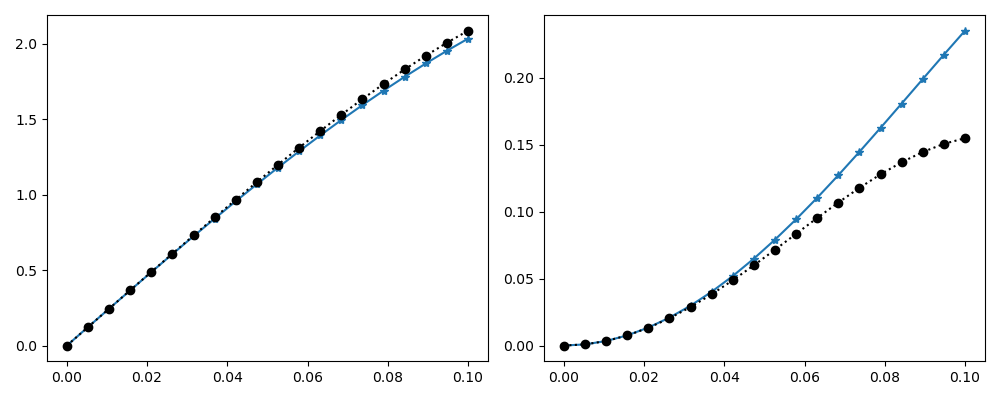

In [114]:

δφ_ext = (φ_ext_values-0.5)

labels = ['I', 'σx', 'σy', 'σz']

Pauli_decomp_list = [ Pauli_p2]
markers= [ '*', 'o']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = [10,4])

for i, Pauli_decomp in enumerate(Pauli_decomp_list):
    ax1.plot(δφ_ext, Pauli_decomp[:,1]-Pauli_decomp[0,1], label=labels[1], marker=markers[i]) 
    ax2.plot(δφ_ext, Pauli_decomp[:,-1]-Pauli_decomp[0,-1], label=labels[-1], marker=markers[i]) 
    
# ax1.plot(δφ_ext, σx_p1, ':k', marker='*')
# ax2.plot(δφ_ext, σz_p1, ':k', marker='*')
 
ax1.plot(δφ_ext, σx_p2, ':k', marker='o')
ax2.plot(δφ_ext, σz_p2, ':k', marker='o')



fig.tight_layout()
fig.show()

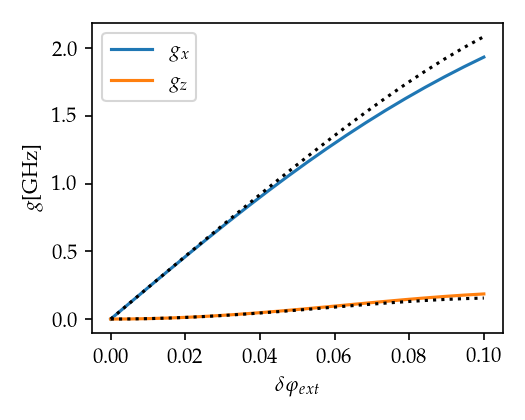

In [136]:

δφ_ext = (φ_ext_values-0.5)

labels = ['I', '$g_x$', '$g_y$', '$g_z$']

Pauli_decomp_list = [ Pauli_SWT]
markers= ['None', '*', 'o']

fig, ax = plt.subplots(dpi=150, figsize=np.array([5,4])*0.7)

for i, Pauli_decomp in enumerate(Pauli_decomp_list):
    ax .plot(δφ_ext, Pauli_decomp[:,1]-Pauli_decomp[0,1], label=labels[1], marker=markers[i]) 
    ax .plot(δφ_ext, Pauli_decomp[:,-1]-Pauli_decomp[0,-1], label=labels[-1], marker=markers[i]) 
    
# ax1.plot(δφ_ext, σx_p1, ':k', marker='*')
# ax2.plot(δφ_ext, σz_p1, ':k', marker='*')
 
ax .plot(δφ_ext, σx_p2, ':k')
ax .plot(δφ_ext, σz_p2, ':k')
ax.legend()
ax.set_xlabel(r'$\delta \varphi_{ext}$')
ax.set_ylabel(r'$g$[GHz]')


fig.tight_layout()
figs.export('fluxonium_vs_phi_ext.pdf',fig)
fig.show()

In [99]:
((Pauli_decomp[:,-1]-Pauli_decomp[0,-1])/ σz_p2)[2]**-1

C:\Users\gabri\AppData\Local\Temp\ipykernel_33452\1669427046.py:1: RuntimeWarning: invalid value encountered in divide
  ((Pauli_decomp[:,-1]-Pauli_decomp[0,-1])/ σz_p2)[2]**-1


-2.637311377770517

In [88]:
((Pauli_decomp[:,1]-Pauli_decomp[0,1])/ σx_p2)[2]

C:\Users\gabri\AppData\Local\Temp\ipykernel_33452\1793786393.py:1: RuntimeWarning: invalid value encountered in divide
  ((Pauli_decomp[:,1]-Pauli_decomp[0,1])/ σx_p2)[2]


0.9992266805455512

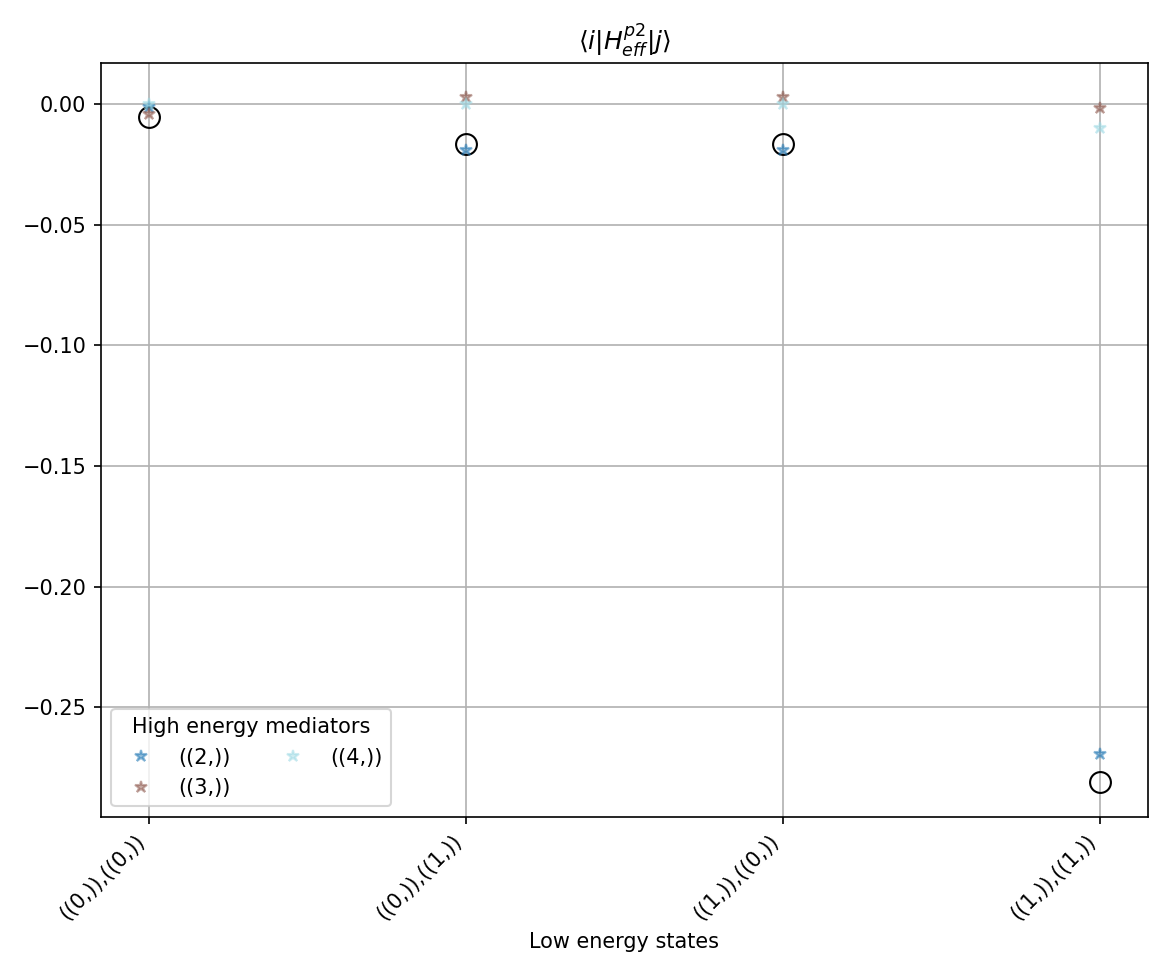

In [369]:
sq_ext.plot_second_order_contributions(H_eff_decomp,labels_low, labels_high)

## Fluxonium + \Phi, $\phi_{ext} \ne 0.5$

In [258]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_1', return_effective=False)


In [259]:
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
fluxonium_0 = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=0.5)
H_0  = fluxonium_0.hamiltonian()


In [269]:
fluxonium   = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=0.55)
H = fluxonium.hamiltonian()

ψ    = sq_ext.diag(H,n_eig=2, solver='numpy')[1]
ψ_0 = sq_ext.diag(H_0,n_eig=2, solver='numpy')[1]

Φ_f  = fluxonium.flux_op(0).__array__()
Φ_f0  = fluxonium_0.flux_op(0).__array__()

In [270]:
ψ.conj().T @ Φ_f @ ψ

array([[-13.8416666 +0.j, -23.98481094+0.j],
       [-23.98481094+0.j,  -2.24825424+0.j]])

In [268]:
ψ_0.conj().T @ Φ_f0 @ ψ_0

array([[-2.92231332e-15+0.j,  2.58265986e+01+0.j],
       [ 2.58265986e+01+0.j, -2.77820728e-14+0.j]])

In [268]:
ψ_0.conj().T @ Φ_f0 @ ψ_0

array([[-2.92231332e-15+0.j,  2.58265986e+01+0.j],
       [ 2.58265986e+01+0.j, -2.77820728e-14+0.j]])

In [246]:
N_elements = 1
basis_states = [(0,), (1,)]
max_excitations_mediating_states=4
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)

In [247]:
φ_ext_values = np.linspace(0.5,0.55, 20)


In [256]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []

for φ_ext  in φ_ext_values:
    fluxonium   = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=φ_ext)
    CF, CR = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
    LF, LR, LC = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
    CR *= fF
    CF *= fF
    LR *= nH
    LF *= nH
    LC *= nH
    Φ_f  = fluxonium.flux_op(0)
    Φ_r  = np.sqrt(0.5*np.sqrt(LR/CR))  
    
    V = Φ_f * Φ_r / LC /2/np.pi/GHz 
    
    H    = H_0 +  V
    
    P1, P2, SWT = sq_ext.H_eff_2x2([H_0], H, basis_states, mediating_states, n_eig=5, n_eig_extra_low=5, return_decomposition=False)
    
    Pauli_p1 .append(P1)
    Pauli_p2 .append(P2)
    Pauli_SWT.append(SWT)

Pauli_p1  = np.array(Pauli_p1 )
Pauli_p2  = np.array(Pauli_p2 )
Pauli_SWT = np.array(Pauli_SWT)


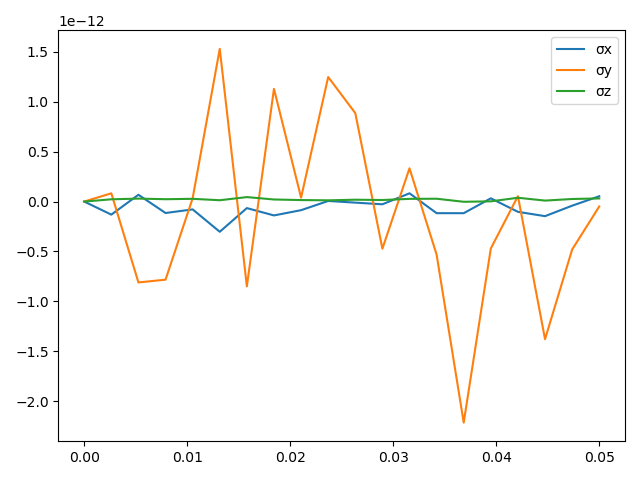

In [257]:
labels = ['I', 'σx', 'σy', 'σz']

Pauli_decomp = Pauli_SWT

fig, ax = plt.subplots( )
for i in range(1,4):
    ax.plot(δφ_ext, Pauli_decomp[:,i]-Pauli_decomp[0,i], label=labels[i]) 
    
ax.legend()
fig.tight_layout()
fig.show()

## Qubit - Cavity 4x4 effective Hamiltonian - vs Delta  

In [62]:
n_eig  = 5
n_plot = 20
param_name = '\\Delta'
param_values = np.geomspace(1e-5, 8, n_plot)
Δ_values = param_values

N_elements = 2
basis_states = [(0,0), (0,1), (1,0), (1,1)]
max_excitations_mediating_states=4
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)
labels_low = [f'({i},{j})' for i, j in basis_states]
labels_high = [f'({i},{j})' for i, j in mediating_states]

n_eig_extra_low = 2

In [63]:
C, CJ, Csh, Lq, Lr, _, EJ = sq_ext.get_experimental_parameters('qubit_2', return_effective=False)
φ_ext=0.5

In [66]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
ω_f_0      = np.zeros(len(Δ_values))
ω_r_0      = np.zeros(len(Δ_values))
g_r_limit  = np.zeros(len(Δ_values))
g_fq_limit = np.zeros(len(Δ_values))
g_xx_pert  = np.zeros(len(Δ_values), dtype='complex')
g_zz_pert  = np.zeros(len(Δ_values), dtype='complex')
g_yy_pert  = np.zeros(len(Δ_values), dtype='complex')
X          = np.zeros(len(Δ_values), dtype='complex')
E_low_vs_Δ = np.zeros([len(Δ_values),4])


for i, Δ in enumerate(Δ_values):
    C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
    L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)
    
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=φ_ext)
    resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ)
    
    H_0, H   = sq_ext.hamiltonian_qubit(fluxonium, resonator, L_C_eff, return_H_0=True)
    
    Hf = fluxonium.hamiltonian()
    Hr = resonator.hamiltonian()
    
    P1, P2, SWT = sq_ext.H_eff_4x4([Hf,Hr], H, basis_states, mediating_states, n_eig=5, n_eig_extra_low=5, return_decomposition=False)
    
    Pauli_p1 .append(P1)
    Pauli_p2 .append(P2)
    Pauli_SWT.append(SWT)
 
    fluxonium.diag(3);
    resonator.diag(3);
    omega_f  = fluxonium.efreqs[1]-fluxonium.efreqs[0]
    omega_f2 = fluxonium.efreqs[2]-fluxonium.efreqs[1]
    omega_r  = resonator.efreqs[1]-resonator.efreqs[0]
    
    Φ_f = fluxonium.flux_op(0, basis='eig')
    Φ_r = resonator.flux_op(0, basis='eig')
    g_xx_pert[i] = 1 / (L_C_eff*nH)  *  (Φ_f[0,1]*Φ_r[0,1]/(2*np.pi*GHz)) 
    g_zz_pert[i] =   ( (1 / (L_C_eff*nH) )**2   * ( 
                    Φ_r[1,2]**2 * Φ_f[0,1]**2/(+omega_r +omega_f  ) +
                    Φ_r[0,1]**2 * Φ_f[1,2]**2/(+omega_r +omega_f2 ) +
                    Φ_r[1,2]**2 * Φ_f[1,2]**2/(-omega_r -omega_f2 ) +
                    Φ_r[1,2]**2 * Φ_f[0,1]**2/(-omega_r +omega_f  ) +
                    Φ_r[0,1]**2 * Φ_f[1,2]**2/(+omega_r -omega_f2 )  
                     )/ (2*np.pi*GHz)**2) / 4
    
    # X[i] =  -2*g_zz_pert[i] + g_xx_pert[i]**2 * ((omega_f-omega_r)**-1 + (omega_f+omega_r)**-1)
    X[i] =  -4*g_zz_pert[i] 
    # X[i] =  g_xx_pert[i]**2 * ((omega_f-omega_r)**-1 + (omega_f+omega_r)**-1)
    ω_f_0[i] = omega_f
    ω_r_0[i] = omega_r
    
    # Analytic estimation of coupling
    E_L_f = sq_ext.L_to_EL(L_F_eff)
    V_fluxonium =  lambda φ: E_L_f*φ**2/2 - EJ*GHz*np.cos(φ+np.pi)
    φ_min = sp.optimize.minimize_scalar(V_fluxonium).x
    
    Φ_f_fq_limit_01 = (Φ_0 / (2 * np.pi)) * φ_min / np.sqrt(sq.hbar) 
    Φ_f_r_limit_01  = np.sqrt(0.5*np.sqrt((L_F_eff * nH)/(C_F_eff * fF)))
    Φ_r_01 = np.sqrt(0.5*np.sqrt((L_R_eff * nH)/(C_R_eff * fF)))
    
    g_fq_limit[i] = 1/(L_C_eff * nH) * Φ_f_fq_limit_01 * Φ_r_01  /2 / np.pi / GHz
    g_r_limit[i] =  1/(L_C_eff * nH) * Φ_f_r_limit_01 * Φ_r_01 /2 / np.pi / GHz
    
Pauli_p1  = np.array(Pauli_p1)
Pauli_p2  = np.array(Pauli_p2)
Pauli_SWT = np.array(Pauli_SWT)

C:\Users\gabri\AppData\Local\Temp\ipykernel_23212\2038207065.py:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax1.plot(L_C_eff_values[::4]**-1, g_xx_pert[::4] * 1e3, '*', color = colors[0], marker='o', markersize='4')
C:\Users\gabri\miniconda3\envs\tunable-cc-fq\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\gabri\AppData\Local\Temp\ipykernel_23212\2038207065.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "*" (-> marker='*'). The keyword argument will take precedence.
  ax1.plot(L_C_eff_values[::4]**-1, g_zz_pert[::4] * 1e3, '*', color = colors[2], marker='o', markersize='4')


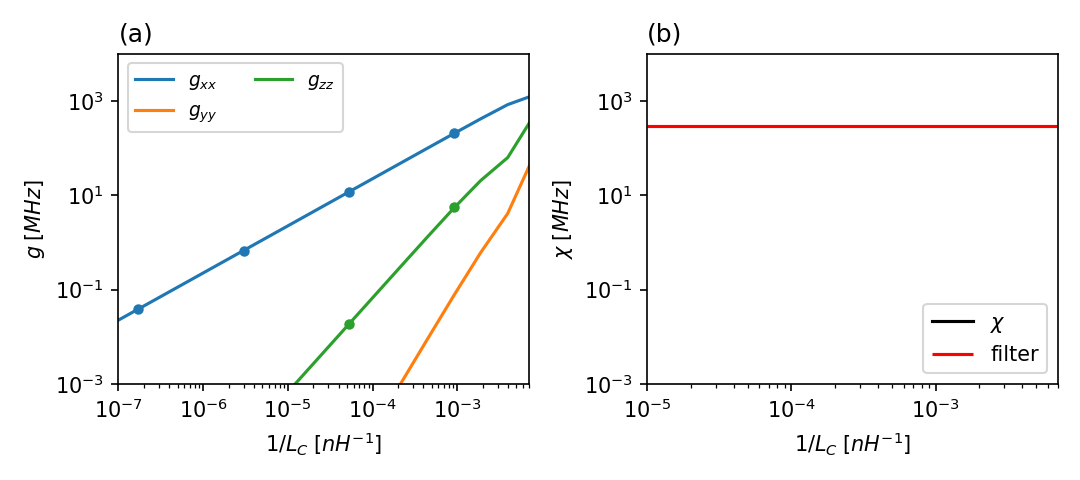

In [67]:
fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize =np.array([9,4])*0.8, dpi=150)
linestyles = ['-', '--','-' ]
colors = figs.generate_colors_from_colormap(10, 'tab10')
set_label  = True

L_C_eff_values = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ_values)[-1]

for i, Pauli in enumerate([Pauli_p1, Pauli_p2, Pauli_SWT]):
    # if i==0 or i==2:
    if i==0 or i==1:
        continue

    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])
    ωf = np.abs(Pauli[:, 0,-1])
    ωr = np.abs(Pauli[:, -1,0])

    ax1.plot(L_C_eff_values**-1, σxσx * 1e3, color = colors[0], linestyle=linestyles[i], label = r'$g_{xx}$')
    ax1.plot(L_C_eff_values**-1, σyσy * 1e3, color = colors[1], linestyle=linestyles[i], label = r'$g_{yy}$')
    ax1.plot(L_C_eff_values**-1, σzσz * 1e3, color = colors[2], linestyle=linestyles[i], label = r'$g_{zz}$')

    # ax1.plot(Δ_values, g_fq_limit, 'x', color = colors[0], label = 'g_{xx}, fluxon', markersize='2')
    # ax1.plot(Δ_values, g_r_limit , 's', color = colors[0], label = 'g_{xx}, plasmon', markersize='2')
    ax1.plot(L_C_eff_values[::4]**-1, g_xx_pert[::4] * 1e3, '*', color = colors[0], marker='o', markersize='4')
    ax1.plot(L_C_eff_values[::4]**-1, g_zz_pert[::4] * 1e3, '*', color = colors[2], marker='o', markersize='4')

    if set_label:
        set_label =False
        ax1.legend(ncol=2, fontsize=9)

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([1e-3,1e4])
ax1.set_xlim([1e-7,7e-3])
ax1.set_ylabel('$g \; [MHz]$')
ax1.set_xlabel('$1/L_C \; [nH^{-1}]$')

E_00 = E_low_vs_Δ[:,0]
E_01 = E_low_vs_Δ[:,1]
E_10 = E_low_vs_Δ[:,2]
E_11 = E_low_vs_Δ[:,3]

X_energies = (E_10-E_00) - (E_11-E_01)

ax2.plot(L_C_eff_values**-1, np.abs(X_energies)*1e3,'k', label='$\chi$')
# ax2.plot(L_C_eff_values[::4]**-1, np.abs(X[::4])*1e3,'.k', label='$\chi$ perturbative')
# ax2.plot(L_C_eff_values[::4]**-1, np.abs(4*g_zz_pert[::4])*1e3,'.k', label='$4g_{zz}$')
 
ax2.hlines(300, 1e-5,7e-3, 'r', label='filter')
 
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim([1e-3,1e4])
ax2.set_xlim([1e-5,7e-3])
ax2.set_ylabel('$\chi\; [MHz]$')
ax2.set_xlabel('$1/L_C \; [nH^{-1}]$')
ax2.legend(loc=4)

ax1.set_title('(a)',loc='left')
ax2.set_title('(b)',loc='left')

# fig.suptitle(r' --- P1 $\quad$ - - P2 $\quad$ $\cdots$ SWT')
fig.tight_layout()
figs.export('g_X_vs_Lc.pdf', fig)
fig.show()

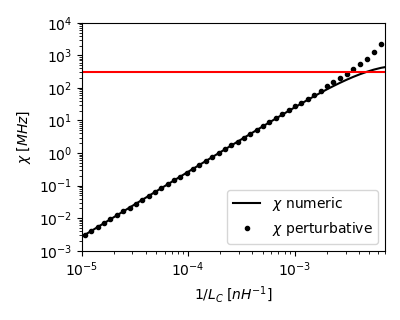

In [166]:
fig, ax = plt.subplots(figsize =np.array([5,4])*0.8, dpi=100)

E_00 = E_low_vs_Δ[:,0]
E_01 = E_low_vs_Δ[:,1]
E_10 = E_low_vs_Δ[:,2]
E_11 = E_low_vs_Δ[:,3]

X_energies = (E_10-E_00) - (E_11-E_01)

ax.plot(L_C_eff_values**-1, np.abs(X_energies)*1e3,'k', label='$\chi$ numeric')
ax.plot(L_C_eff_values**-1, np.abs(X)*1e3,'.k', label='$\chi$ perturbative')

ax.hlines(300, 1e-5,7e-3, 'r')


ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e-3,1e4])
ax.set_xlim([1e-5,7e-3])
ax.set_ylabel('$\chi\; [MHz]$')
ax.set_xlabel('$1/L_C \; [nH^{-1}]$')
ax.legend(loc=4)

fig.tight_layout()
fig.show()

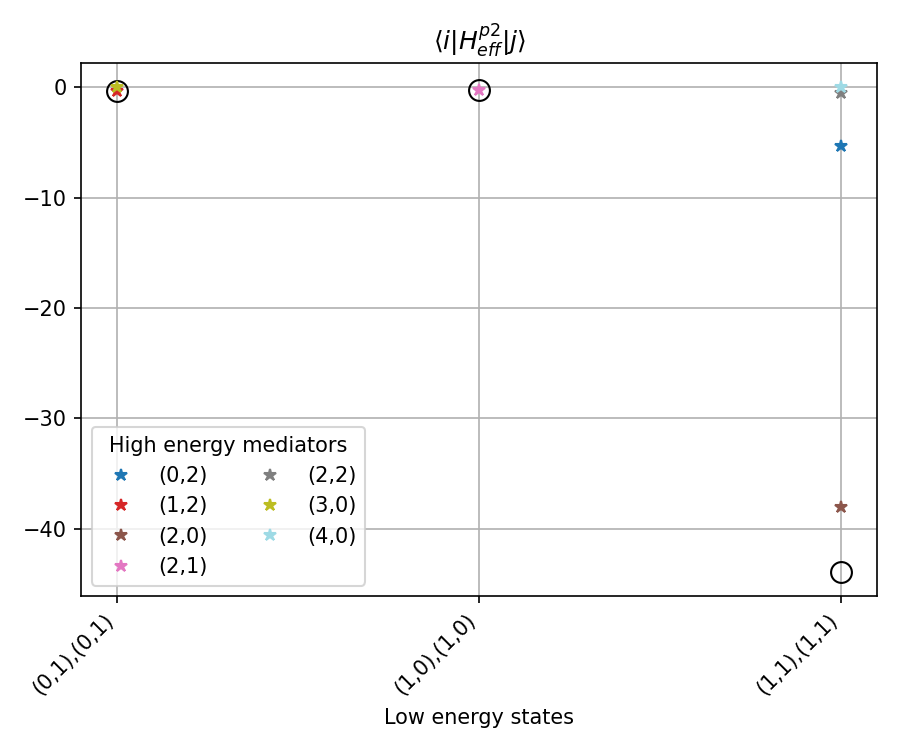

In [145]:
sq_ext.plot_second_order_contributions(H_eff_p2_decomposed, labels_low, labels_high,figsize=np.array([6, 5]) * 1 ,threshold =1e-4)

## Dispersive shift vs n

In [5]:
N_elements = 2
basis_states = []
N = 15
for i in range(N):
    basis_states.append((0,i))
    basis_states.append((1,i))
    
nmax_f = 25
nmax_r = 35
n_eig_H= 150
n_eig_f = 2
n_eig_r = N+10

C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_2', return_effective=False)
# Δ=10
φ_ext=0.5

In [6]:
C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)

fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=φ_ext, nmax_f=nmax_f )
resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ, nmax_r=nmax_r )

H_0, H   = sq_ext.hamiltonian_qubit(fluxonium = fluxonium, resonator = resonator, LC=L_C_eff, return_H_0=True)

Hf = fluxonium.hamiltonian()
Hr = resonator.hamiltonian()

ψ0_f         = sq_ext.diag(Hf, n_eig_f, solver='numpy', real=True)[1]
ψ0_r         = sq_ext.diag(Hr, n_eig_r, solver='numpy', real=True)[1]

ψ_0_low = [ qt.tensor(qt.Qobj(ψ0_f[:,i]), qt.Qobj(ψ0_r[:,j]))  for i, j in basis_states]
E_0_ψ_0_low  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0_low]

E_0  = sq_ext.diag(H_0  , n_eig=n_eig_H, out='GHz', solver='scipy')[0]
E, ψ = sq_ext.diag(H  , n_eig=n_eig_H, out='GHz', solver='Qutip', qObj=True)

subspace_indices = sq_ext.find_close_indices(E_0_ψ_0_low,E_0)
E_basis_states = E[subspace_indices]

C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:1457: RuntimeWarning: invalid value encountered in divide
  avgz = avgz / np.abs(avgz)


In [11]:
fluxonium.diag(3);
resonator.diag(3);
omega_f  = fluxonium.efreqs[1]-fluxonium.efreqs[0]
omega_f2 = fluxonium.efreqs[2]-fluxonium.efreqs[1]
omega_r  = resonator.efreqs[1]-resonator.efreqs[0]

Φ_f = fluxonium.flux_op(0, basis='eig')
Φ_r = resonator.flux_op(0, basis='eig')
X1       =   ( (1 / (L_C_eff*nH) )**2   * ( 
                Φ_r[1,2]**2 * Φ_f[0,1]**2/(+omega_r +omega_f  ) +
                Φ_r[0,1]**2 * Φ_f[1,2]**2/(+omega_r +omega_f2 ) +
                Φ_r[1,2]**2 * Φ_f[1,2]**2/(-omega_r -omega_f2 ) +
                Φ_r[1,2]**2 * Φ_f[0,1]**2/(-omega_r +omega_f  ) +
                Φ_r[0,1]**2 * Φ_f[1,2]**2/(+omega_r -omega_f2 )  
                 )/ (2*np.pi*GHz)**2)

# X2 = ( (1 / (L_C_eff*nH) )**2   * ( 
#                 Φ_r[0,1]**2 * Φ_f[0,1]**2 * ( 1/(omega_f - omega_r ) + 1/(omega_f + omega_r ) )
#                  )/ (2*np.pi*GHz)**2) * 2

X2 = ( (1 / (L_C_eff*nH) )**2   * ( 
                Φ_r[0,1]**2 * Φ_f[0,1]**2 * ( 1/(omega_f - omega_r ) )
                 )/ (2*np.pi*GHz)**2) 

In [12]:
ω_vs_n = E_basis_states[1::2] - E_basis_states[::2]
X_vs_n = ω_vs_n[1:]-ω_vs_n[0]
n = np.arange(1,N)

C:\Users\gabri\miniconda3\envs\tunable-cc-fq\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


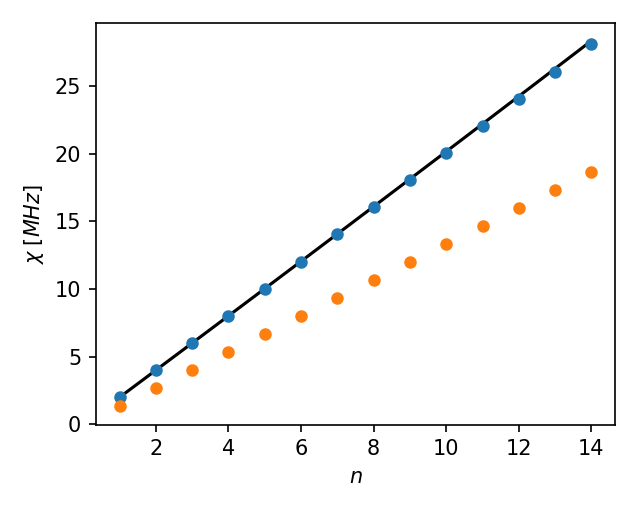

In [13]:
fig, ax = plt.subplots(figsize =np.array([5,4])*0.85, dpi=150)

ax.plot(n,  X_vs_n * 1e3,'k', label='$\chi$')
ax.plot(n,  X1 * n * 1e3,'.', markersize=10, label='')
ax.plot(n, -X2 * n * 1e3,'.', markersize=10)


# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim([1e-3,1e4])
# ax.set_xlim([1e-5,7e-3])
ax.set_ylabel('$\chi\; [MHz]$')
ax.set_xlabel('$n$')

fig.tight_layout()

# figs.export('chi_vs_n.pdf', fig)
fig.show()

## Qubit - Cavity 4x4 effective Hamiltonian - vs $\varphi_{ext}$

In [316]:
n_eig  = 6

n_plot = 20
param_name = '\\varphi_{ext}'
param_values = np.linspace(0.5, 0.55, n_plot)
φ_ext_values = param_values

N_elements = 2
basis_states = [(0,0), (0,1), (1,0), (1,1)]
max_excitations_mediating_states=3
mediating_states = sq_ext.generate_mediating_states(N_elements, basis_states, max_excitations_mediating_states)
labels_low = [f'({i},{j})' for i, j in basis_states]
labels_high = [f'({i},{j})' for i, j in mediating_states]

n_eig_extra_low = 1

In [317]:
C, CJ, Csh, Lq, Lr, Δ, EJ = sq_ext.get_experimental_parameters('qubit_2', return_effective=False)

In [323]:
Pauli_p1 = []
Pauli_p2 = []
Pauli_SWT = []
H_eff_decomp_list = []

C_F_eff, C_R_eff = sq_ext.C_CJ_Csh_to_CF_CR_eff(C, CJ, Csh)
L_F_eff, L_R_eff, L_C_eff = sq_ext.Lq_Lr_to_LF_LR_LC_eff(Lq, Lr, Δ)

# L_C_eff *= 1/50

fluxonium_0 = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=0.5)
resonator = sq_ext.sq_resonator(L_R_eff=L_R_eff, C_R_eff=C_R_eff, Δ=Δ)
Hf = fluxonium_0.hamiltonian()
Hr = resonator.hamiltonian()
H_0_list =[Hf,Hr]
# H = sq_ext.hamiltonian_qubit(fluxonium_0, resonator, L_C_eff )

for i, φ_ext in enumerate(φ_ext_values):
    fluxonium = sq_ext.sq_fluxonium(EJ=EJ, C_F_eff=C_F_eff, Lq=L_F_eff, Δ=Δ, φ_ext=φ_ext)
    H = sq_ext.hamiltonian_qubit(fluxonium, resonator, L_C_eff )
    
    # SWT = sq_ext.decomposition_in_pauli_4x4( sq_ext.H_eff_SWT(H_0, H, n_eig=4), print_pretty=False)
    
    P1, P2, SWT, H_eff_decomp = sq_ext.H_eff_4x4(H_0_list, H, basis_states, mediating_states, n_eig=n_eig, n_eig_extra_low=n_eig_extra_low, return_decomposition=True)
#     
    Pauli_p1 .append(P1)
    Pauli_p2 .append(P2)
    Pauli_SWT.append(SWT)
    H_eff_decomp_list.append(H_eff_decomp)
#     
Pauli_p1  = np.array(Pauli_p1)
Pauli_p2  = np.array(Pauli_p2)
Pauli_SWT = np.array(Pauli_SWT)

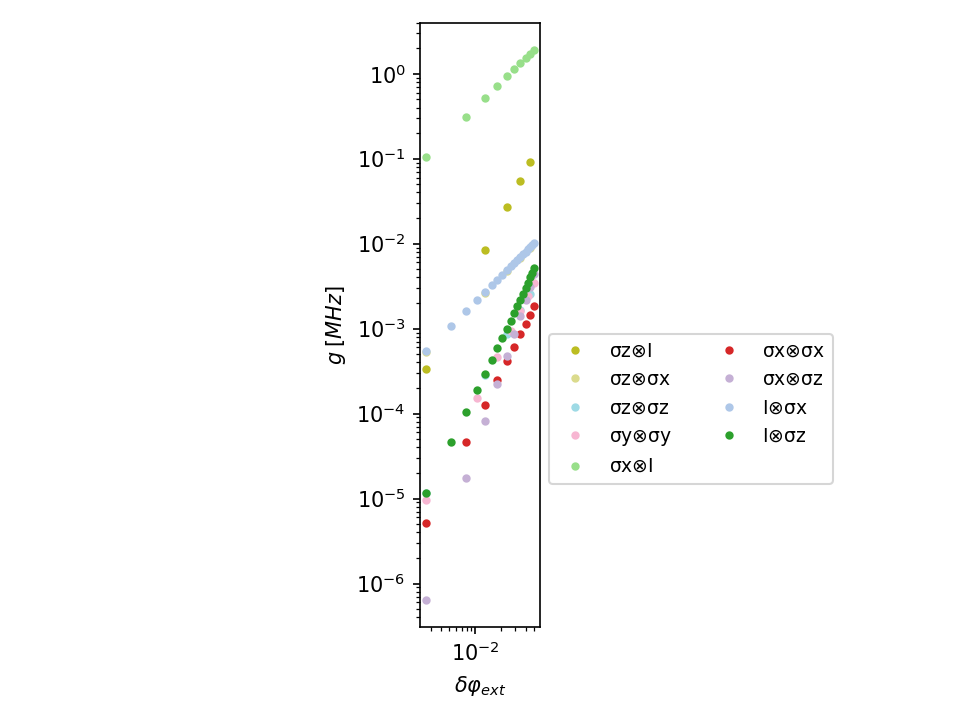

In [351]:
fig, ax1 = plt.subplots( dpi=150)
linestyles = ['-', '--','-' ]
labels = ['I', 'σx', 'σy', 'σz']
colors = figs.generate_colors_from_colormap(16, 'tab20')
# colors = figs.generate_colors_from_colormap(9, 'Set1') + figs.generate_colors_from_colormap(9, 'Set2')

Pauli_decomp = Pauli_p2

for i in reversed(range(4)):
    for j in range(4):
        if i==j==0:
            continue
        if np.any( np.abs(Pauli_decomp[1:,i,j]- Pauli_decomp[0,i,j]) >1e-12):
            ax1.plot(φ_ext_values[1::i+1]-0.5,np.abs(Pauli_decomp[1:,i,j]- Pauli_decomp[0,i,j])[::i+1],  '.',color = colors[i*4+j], label = f'{labels[i]}' + r'$\otimes$' + f'{labels[j]}' )

ax1.set_yscale('log')
ax1.set_xscale('log')
# ax1.set_ylim([1e-5,1e1])
# ax1.set_xlim([1e-7,7e-3])
ax1.set_ylabel('$g \; [MHz]$')
ax1.set_xlabel(r'$\delta\varphi_{ext}$')
ax1.set_aspect('equal')
ax1.legend(ncol=2, fontsize=9, bbox_to_anchor=(1, 0., 0.5, 0.5))

fig.tight_layout()
fig.show()

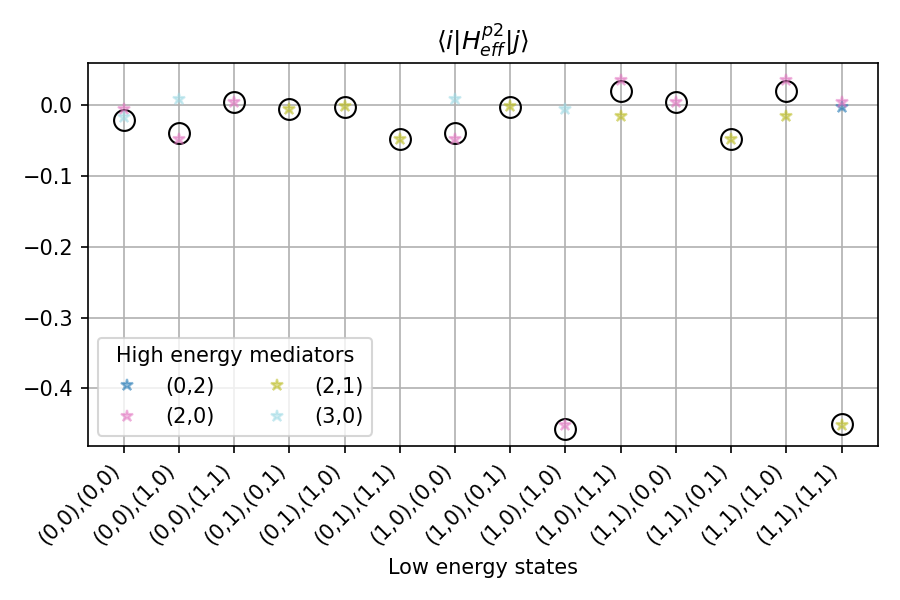

In [341]:
sq_ext.plot_second_order_contributions(H_eff_decomp,labels_low, labels_high, figsize=[6,4], threshold=1e-3)

In [329]:
H_eff = np.sum(H_eff_decomp, -1)
nonzero_indices = np.where(np.abs(H_eff) > 1e-3)

In [333]:
plotted_terms = []

In [335]:
plotted_terms.append((0,2))

In [337]:
(1,0) in plotted_terms

False

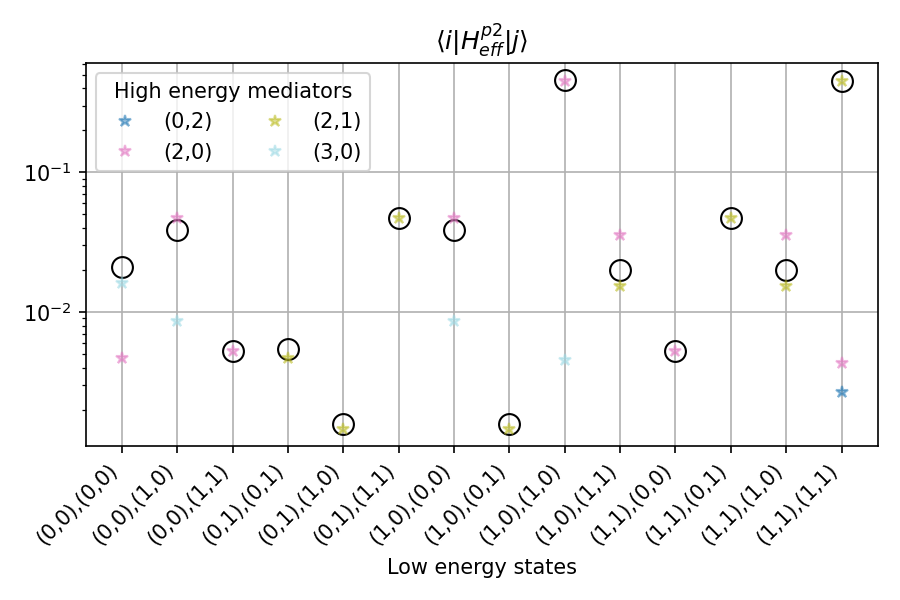

In [347]:
sq_ext.plot_second_order_contributions_log(H_eff_decomp,labels_low, labels_high, figsize=[6,4], threshold=1e-3)

In [348]:
σ_x ,σ_y ,σ_z = sq_ext.pauli_matrices()

In [350]:
np.kron(σ_x,σ_x)

array([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])